In [59]:
import pandas as pd
import numpy as np
import gzip
import itertools
import plotnine as p9
import datetime




In [60]:
df = pd.read_csv(gzip.open('data/manipulation/tidied_geolocated_data.csv.gz', 'rb'))
df.tail()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob,high_amend,low_amend
293629,15525,MZM-1989-3-1347-4,1989,1,Clear,3,498,562,Renamo - Civilians,498,...,0,9,0,9,9,9,NaN,NaN,9,9
293630,15524,MZM-1989-3-1347-16,1989,1,Clear,3,498,562,Renamo - Civilians,498,...,0,9,0,9,9,9,NaN,NaN,9,9
293631,15245,MZM-1990-3-1347-18,1990,1,Clear,3,498,562,Renamo - Civilians,498,...,0,7,0,7,7,7,NaN,NaN,7,7
293632,15516,MZM-1990-3-1347-28,1990,1,Clear,3,498,562,Renamo - Civilians,498,...,0,1,0,1,1,1,NaN,NaN,1,1
293633,15493,MZM-1990-3-1347-29,1990,1,Clear,3,498,562,Renamo - Civilians,498,...,0,6,0,6,6,6,NaN,NaN,6,6


### Aggregate – annual

#### A note on conflict IDs

Conflicts don't seem to have more than one type of violence within a single year. (This wasn't the case with earlier versions of the dataset I think).

In [61]:
df_test_agg = df.groupby(['conflict_new_id', 'year'])['type_of_violence'].nunique()
df_test_agg = df_test_agg.reset_index()
df_test_agg.loc[(df_test_agg.type_of_violence>1),].head()

,conflict_new_id,year,type_of_violence


Conflicts can take place in more than region (in a single year) though.

In [62]:
df_test_agg = df.groupby(['conflict_new_id', 'year'])['region'].nunique()
df_test_agg = df_test_agg.reset_index()
df_test_agg.loc[(df_test_agg.region>1),].head()

,conflict_new_id,year,region
213,234,1992,2
216,234,1995,2
303,259,2015,3
304,259,2016,3
305,259,2017,3


That means that the number of conflicts broken down by region won't exactly sum up to the global totals in these years.

This is a function that, grouped by specified cols, sums over a range of cols and counts unique values over a range of cols.

## Basic function for doing aggregations

In [63]:
def my_aggregation(df, cols_to_group_by):
    
    # Some columns we will be summing the values (i.e. deaths)
    cols_to_sum = ['best', 'low_amend', 'high_amend']
    
    # Some columns we will be couting unique values (i.e. conflict ids)
    cols_to_count = 'conflict_new_id'
     
    # Sum deaths    
    df_deaths_agg = df.groupby(cols_to_group_by)[cols_to_sum].sum()
    df_deaths_agg = df_deaths_agg.reset_index()

    # Count conflicts   
    df_confl_agg = df.groupby(cols_to_group_by)[cols_to_count].nunique()
    df_confl_agg = df_confl_agg.reset_index()

    df_confl_agg.rename(columns = {"conflict_new_id":"number_of_conflicts"}, inplace = True)

    # Merge deaths and count together (merging on cols_to_group_by)
    df_agg = pd.merge(df_deaths_agg, df_confl_agg)
        
    return df_agg

#### Aggregate broken down by type of violence

Aggregate by type of violence and year and...

...by region (according to UCDP region definitions)

In [64]:
df_bytype_region_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['region','type_of_violence', 'year']
    )

df_bytype_region_agg.rename(columns = {"region":"entity"}, inplace = True)

df_bytype_region_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Africa,1,1989,34546,34516,47458,13
1,Africa,1,1990,64847,62499,78847,15
2,Africa,1,1991,25510,23653,35629,19
3,Africa,1,1992,6922,6814,23260,17
4,Africa,1,1993,15091,15084,27251,15


.. for world total

In [65]:
df_bytype_world_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['type_of_violence', 'year']
    )

df_bytype_world_agg['entity'] = "World"

df_bytype_world_agg.head()

,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts,entity
0,1,1989,54629,50419,84773,50,World
1,1,1990,80316,77097,97825,55,World
2,1,1991,70423,68135,91553,58,World
3,1,1992,53595,50128,78736,65,World
4,1,1993,45055,43969,67024,58,World


#### Aggregate over all conflict types

...by region (according to UCDP region definitions)

In [66]:
df_alltype_region_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['region','year']
    )

df_alltype_region_agg.rename(columns = {"region":"entity"}, inplace = True)

df_alltype_region_agg['type_of_violence'] = 999 # create a code for 'all types' – to be recoded later

df_alltype_region_agg.head()

,entity,year,best,low_amend,high_amend,number_of_conflicts,type_of_violence
0,Africa,1989,40608,40576,60459,38,999
1,Africa,1990,72854,70236,90014,51,999
2,Africa,1991,33990,31987,46716,68,999
3,Africa,1992,18582,17926,41008,79,999
4,Africa,1993,34139,30426,57038,83,999


.. for world total

In [67]:
df_alltype_world_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['year']
    )

df_alltype_world_agg['entity'] = "World"

df_alltype_world_agg['type_of_violence'] = 999 # code for 'all types'


df_alltype_world_agg.head()

,year,best,low_amend,high_amend,number_of_conflicts,entity,type_of_violence
0,1989,66935,60510,108021,127,World,999
1,1990,95656,91319,120368,150,World,999
2,1991,84277,81316,110277,157,World,999
3,1992,76074,71643,110627,192,World,999
4,1993,67273,62270,103335,188,World,999


Append aggregate dfs together

In [68]:
frames = [
    df_bytype_region_agg, 
    df_bytype_world_agg,
    df_alltype_region_agg, 
    df_alltype_world_agg
    ]

df_agg = pd.concat(frames)
df_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Africa,1,1989,34546,34516,47458,13
1,Africa,1,1990,64847,62499,78847,15
2,Africa,1,1991,25510,23653,35629,19
3,Africa,1,1992,6922,6814,23260,17
4,Africa,1,1993,15091,15084,27251,15


Rename variables and restructure for grapher

In [69]:
type_text = {1: "State-based conflict",
             2: "Non-state conflict",
             3: "One-sided violence",
             999: "All types of organised violence"}

df_agg = df_agg.replace(dict(type_of_violence = type_text))

df_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Africa,State-based conflict,1989,34546,34516,47458,13
1,Africa,State-based conflict,1990,64847,62499,78847,15
2,Africa,State-based conflict,1991,25510,23653,35629,19
3,Africa,State-based conflict,1992,6922,6814,23260,17
4,Africa,State-based conflict,1993,15091,15084,27251,15


### Merge in a complete grid of region-years to add 'zeros' for where no events occurred.

In [70]:
# Extract unique values from the 'region' column of the data
regions = df['region'].unique().tolist()

# Append one 'World' region to the list
regions.append('World')


# Get the minimum and maximum values from the 'year' column of df2
min_year = df['year'].min()
max_year = df['year'].max()

# Create the years list using the minimum and maximum values
years = list(range(min_year, max_year + 1))


# Types of violence
violence_types = list(type_text.values())



In [71]:
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [72]:
grid = expand_grid(
   .....:    {'entity':regions,
   .....:     'year': years,
   .....:     'type_of_violence': violence_types})

In [73]:
grid.tail()

,entity,year,type_of_violence
787,World,2020,All types of organised violence
788,World,2021,State-based conflict
789,World,2021,Non-state conflict
790,World,2021,One-sided violence
791,World,2021,All types of organised violence


Merge in actual UCDP data to empty grid (this creates NaNs for missing rows)

In [74]:
df_agg = pd.merge(grid, df_agg, how='left')

In [75]:
df_agg.head()

,entity,year,type_of_violence,best,low_amend,high_amend,number_of_conflicts
0,Asia,1989,State-based conflict,9779.0,6264.0,23880.0,20.0
1,Asia,1989,Non-state conflict,1215.0,1213.0,1625.0,10.0
2,Asia,1989,One-sided violence,3436.0,1748.0,5933.0,17.0
3,Asia,1989,All types of organised violence,14430.0,9225.0,31438.0,47.0
4,Asia,1990,State-based conflict,10092.0,9664.0,12683.0,22.0


Replace NaN with zeros

In [76]:
df_agg[['best', 'low_amend', 'high_amend', 'number_of_conflicts']] = df_agg[['best', 'low_amend', 'high_amend', 'number_of_conflicts']].fillna(0)

### Visual sense check

In [77]:
select_regions = ["Asia", "World"]
select_types = ["All types of organised violence"]
select_deaths_var = "best"

df_filter = df_agg[df_agg.entity.isin(select_regions)]
df_filter = df_filter[df_filter.type_of_violence.isin(select_types)]



In [78]:
df_filter

,entity,year,type_of_violence,best,low_amend,high_amend,number_of_conflicts
3,Asia,1989,All types of organised violence,14430.0,9225.0,31438.0,47.0
7,Asia,1990,All types of organised violence,14665.0,14029.0,18307.0,55.0
11,Asia,1991,All types of organised violence,17800.0,17410.0,20431.0,44.0
15,Asia,1992,All types of organised violence,19649.0,19540.0,24611.0,56.0
19,Asia,1993,All types of organised violence,10672.0,10607.0,18056.0,52.0
...,...,...,...,...,...,...,...
775,World,2017,All types of organised violence,104726.0,99716.0,127449.0,298.0
779,World,2018,All types of organised violence,86105.0,80204.0,102750.0,298.0
783,World,2019,All types of organised violence,78140.0,72297.0,90168.0,293.0
787,World,2020,All types of organised violence,82773.0,77196.0,95496.0,299.0


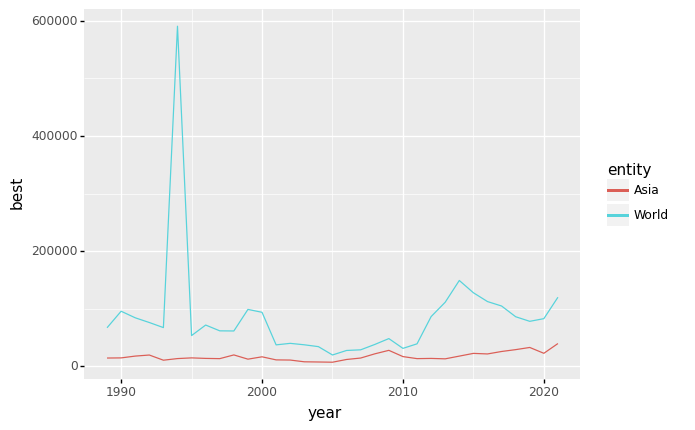

<ggplot: (388382416)>

In [79]:
(p9.ggplot(data=df_filter,
          mapping=p9.aes(x='year',y=select_deaths_var, colour = 'entity'))
     + p9.geom_line()
)

## Pivot wider for Grapher

In [80]:
# Pivot the dataframe wider
df_wider = pd.pivot_table(df_agg, index=['entity', 'year'], columns='type_of_violence', values=['best', 'low_amend', 'high_amend', 'number_of_conflicts'])

# Flatten the column names
df_wider.columns = ['_'.join(col) for col in df_wider.columns]


In [81]:
df_wider.head()

best_All types of organised violence  best_Non-state conflict  \
entity year                                                                  
Africa 1989                               40608.0                   2524.0   
       1990                               72854.0                   1382.0   
       1991                               33990.0                   2740.0   
       1992                               18582.0                   7490.0   
       1993                               34139.0                  11120.0   

             best_One-sided violence  best_State-based conflict  \
entity year                                                       
Africa 1989                   3538.0                    34546.0   
       1990                   6625.0                    64847.0   
       1991                   5740.0                    25510.0   
       1992                   4170.0                     6922.0   
       1993                   7928.0                    15091.0   

             high_amend_All types of organised violence  \
entity year                                               
Africa 1989                                     60459.0   
       1990                                     90014.0   
       1991                                     46716.0   
       1992                                     41008.0   
       1993                                     57038.0   

             high_amend_Non-state conflict  high_amend_One-sided violence  \
entity year                                                                 
Africa 1989                         3573.0                         9428.0   
       1990                         2128.0                         9039.0   
       1991                         4465.0                         6622.0   
       1992                        11745.0                         6003.0   
       1993                        15576.0                        14211.0   

             high_amend_State-based conflict  \
entity year                                    
Africa 1989                          47458.0   
       1990                          78847.0   
       1991                          35629.0   
       1992                          23260.0   
       1993                          27251.0   

             low_amend_All types of organised violence  \
entity year                                              
Africa 1989                                    40576.0   
       1990                                    70236.0   
       1991                                    31987.0   
       1992                                    17926.0   
       1993                                    30426.0   

             low_amend_Non-state conflict  low_amend_One-sided violence  \
entity year                                                               
Africa 1989                        2524.0                        3536.0   
       1990                        1382.0                        6355.0   
       1991                        2646.0                        5688.0   
       1992                        7259.0                        3853.0   
       1993                        8311.0                        7031.0   

             low_amend_State-based conflict  \
entity year                                   
Africa 1989                         34516.0   
       1990                         62499.0   
       1991                         23653.0   
       1992                          6814.0   
       1993                         15084.0   

             number_of_conflicts_All types of organised violence  \
entity year                                                        
Africa 1989                                               38.0     
       1990                                               51.0     
       1991                                               68.0     
       1992                                               79.0     
       1993                       

## Write to csv

In [82]:
df_agg.to_csv('data/output/ucdp_geolocated_data_by_region_and_violence_type.csv.gz', index = False, compression = "gzip")